## Scraping Property Access PH through Selenium
This notebook was prepared by Adem Inovejas, Christopher Lim, Czarina Tiu, and Uriel Grace Magtibay (students of DATA102 S11 Y2022-2023).  

In your notebook, make sure you have the following details outlined:
- The website scraped
- Date and time when the data was collected
- What were the challenges encountered? You may narrate or illustrate this in the notebook.
- Do you think the collected data contains any personally identifiable information (PII)?
- Conclude with your key learnings and findings.

## Importing Libaries

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import os
import datetime
import time

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

## Setup

In [4]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.29M/6.29M [00:01<00:00, 3.97MB/s]


In [3]:
url = "https://propertyaccess.ph/offer/sale"
driver.get(url)

## Data Collection

### Collecting  the URLs of each properties

The website is structured with multiple pages with each page having approximately 20 property listings. Each property listing is shown on the main page as a clickable widget, that when clicked, will redirect to a new page with more information regarding the property listing. So the first step in our data collection process was to collect the url of each property across the website. 

In [4]:
has_pages = True
pages = 1
urls = []
total_time = 0
while(has_pages):  
    start = time.perf_counter()
    
    products_container = driver.find_element(by="xpath", value='//div[@class="list-product page-content"]')
    
    # gets the list of products
    items = products_container.find_elements(by="xpath", value='.//div[@class="product-wrapper"]')
    for item in items:
        # get the href of the anchor of "product-img"
        url = item.find_element(by="xpath", value='.//div[@class="product-img"]/a').get_attribute('href')
        date_published = item.find_element(by="xpath", value='.//div[@class="date"]').text
        urls.append((url, date_published))
    
    end = time.perf_counter()
    
    total_time += end - start
    print('Extracted Page %d | %d items found | %.2fs' % (pages, len(items), end - start))
    try:
        # checks if next page button is available by getting the xpath
        next_page = driver.find_element("xpath", value='//ul[@class="pargination"]/li[@class="next flex-end"]/a').get_attribute("href");
        driver.get(next_page)
        pages += 1
    except:
        # if next page button is not available, stop the loop
        has_pages = False

print('Number of pages:', pages)
print('Number of products:', len(urls))
print('Average Time per page:', total_time / len(urls))
print('Total Time:', total_time)

Extracted Page 1 | 20 items found | 0.57s
Extracted Page 2 | 20 items found | 0.58s
Extracted Page 3 | 20 items found | 0.60s
Extracted Page 4 | 20 items found | 0.62s
Extracted Page 5 | 20 items found | 0.74s
Extracted Page 6 | 20 items found | 0.72s
Extracted Page 7 | 20 items found | 0.75s
Extracted Page 8 | 20 items found | 0.68s
Extracted Page 9 | 20 items found | 0.70s
Extracted Page 10 | 20 items found | 0.71s
Extracted Page 11 | 20 items found | 0.70s
Extracted Page 12 | 20 items found | 0.75s
Extracted Page 13 | 20 items found | 0.67s
Extracted Page 14 | 20 items found | 0.74s
Extracted Page 15 | 20 items found | 0.73s
Extracted Page 16 | 20 items found | 0.67s
Extracted Page 17 | 20 items found | 0.69s
Extracted Page 18 | 20 items found | 0.69s
Extracted Page 19 | 20 items found | 0.68s
Extracted Page 20 | 20 items found | 0.73s
Extracted Page 21 | 20 items found | 0.65s
Extracted Page 22 | 20 items found | 0.69s
Extracted Page 23 | 20 items found | 0.66s
Extracted Page 24 | 

Exporting the URLs through pandas dataframe (as .csv)

In [6]:
df = pd.DataFrame(urls, columns=['URL', 'Date Published'])
df.head()

,URL,Date Published
0,https://propertyaccess.ph/property/3-br-condo-...,Published on: 30/03/2022
1,https://propertyaccess.ph/property/1br-condo-i...,Published on: 30/03/2022
2,https://propertyaccess.ph/property/3-bedroom-c...,Published on: 17/07/2022
3,https://propertyaccess.ph/property/3-bedroom-c...,Published on: 17/07/2022
4,https://propertyaccess.ph/property/2br-condo-i...,Published on: 1/06/2022


In [7]:
df.to_csv('property_urls.csv', index=False)

### Going through each property page to get the details

With the urls obtained in the previous step, each url will be scrapped for information about the property. The data obtained in this step are property details (name, address, price, author), utility information (bedroom, showers, furnish, parking, lot area), features, and the timestamp that notes what date and time the information was collected


In [4]:
df = pd.read_csv('property_urls.csv')
df.head()

,URL,Date Published
0,https://propertyaccess.ph/property/3-br-condo-...,Published on: 30/03/2022
1,https://propertyaccess.ph/property/1br-condo-i...,Published on: 30/03/2022
2,https://propertyaccess.ph/property/3-bedroom-c...,Published on: 17/07/2022
3,https://propertyaccess.ph/property/3-bedroom-c...,Published on: 17/07/2022
4,https://propertyaccess.ph/property/2br-condo-i...,Published on: 1/06/2022


In [5]:
data = []
total_time = 0
for i, item in enumerate(list(zip(df['URL'], df['Date Published']))):
    try:
        start = time.perf_counter()
        url, date_published = item
        driver.get(url)

        # get the container which contains the property details
        property_details = driver.find_element(by="xpath", value='//div[@class="product-detail-wraper"]')

        # find the name
        name = property_details.find_element(by="xpath", value='.//h1[@class="basic-info__name"]').text
        address = property_details.find_element(by="xpath", value='.//div[@class="basic-info__street"]').text
        price = property_details.find_element(by="xpath", value='.//div[@class="basic-info__price"]').text
        author = property_details.find_element(by="xpath", value='.//div[@class="agent-name line-clamp lc-2"]').text

        # get the bedrooms, showers, parking, furnish type, total developed and lot area through utility info
        utility_info = property_details.find_element(by="xpath", value='.//div[@class="basic-info__utilities"]')

        try:
            bedrooms = utility_info.find_element(by="xpath", value='//img[@data-src="https://cdn.propertyaccess.ph/prod/v1.2.6/f24d0f0d48276caeca2060fd60abf269.svg"]/..').text
        except:
            bedrooms = None

        try:
            showers = utility_info.find_element(by="xpath", value='//img[@data-src="https://cdn.propertyaccess.ph/prod/v1.2.6/a6e500c94a1eaacdd59fde045fba89f0.svg"]/..').text
        except:
            showers = None

        try:
            furnish = utility_info.find_element(by="xpath", value='//img[@data-src="https://cdn.propertyaccess.ph/prod/v1.2.6/9fb04d2eb34997da34e3dcfd140f51b6.svg"]/..').text
        except:
            furnish = None

        try:
            parking = utility_info.find_element(by="xpath", value='//img[@data-src="https://cdn.propertyaccess.ph/prod/v1.2.6/33d487e03cfed78b821458ab3c39b574.svg"]/..').text
        except:
            parking = None

        try:
            total_developed = utility_info.find_element(by="xpath", value='//img[@data-src="https://cdn.propertyaccess.ph/prod/v1.2.6/57cebe2c8bcb0aa7f604503ddb740621.svg"]/..').text
        except:
            total_developed = None

        try:
            lot_area = utility_info.find_element(by="xpath", value='//img[@data-src="https://cdn.propertyaccess.ph/prod/v1.2.6/da2ffe9d4238be9a3d697b4195b64fe7.svg"]/..').text
        except:
            lot_area = None

        # if section title is Property Features or Amenities
        features = [feature.text for feature in property_details.find_elements(by="xpath", value='.//section[@class="product-feature"]//div[text()="Property Features" or text()="Amenities"]/..//div[@class="item-listing readmore-target"]//p')]

        # if section title is Facilities
        facilities = [facility.text for facility in property_details.find_elements(by="xpath", value='.//section[@class="product-feature"]//div[text()="Facilities"]/..//div[@class="item-listing readmore-target"]//p')]

        # if section title is Nearby Places
        nearby_places = [place.text for place in property_details.find_elements(by="xpath", value='.//section[@class="product-nearby"]//div[@class="item-title"]')]

        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        end = time.perf_counter()

        total_time += end - start
        
        print('[%4d] %s | %.2fs' % (i, name, end - start))

        data.append((name, address, author, price, bedrooms, showers, parking, furnish, total_developed, lot_area, features, facilities, nearby_places, url, timestamp))
    except:
        # if page is un-available
        print('Error occured on', url)

[   0] 3 BR Condo in The Grand Midori Ortigas, Pasig | 1.72s
[   1] 1 Bedroom Condo in The Grand Midori Ortigas, Pasig | 1.26s
[   2] 3 Bedroom Condo in Aurelia Residences, Taguig | 1.55s
[   3] 3 Bedroom Condo in Shang Residences at Wack Wack, Mandaluyong | 1.56s
[   4] 2BR Condo in Residences at The Galleon, Pasig | 1.91s
[   5] Penthouse in Residences at The Galleon, Pasig | 2.93s
[   6] 3 Bedroom Condo in Aurelia Residences, Taguig | 2.07s
[   7] 3 Bedroom Condo in Valencia Hills Tower E, Quezon City | 2.41s
[   8] 2 Bedroom Condo in Valencia Hills Tower E, Quezon City | 1.35s
[   9] 1 Bedroom Condo in Valencia Hills Tower E, Quezon City | 1.16s
[  10] 3 Bedroom Condo in Aurelia Residences, Taguig | 1.96s
[  11] 2 Bedroom Condo in The Rise Makati, Makati | 2.06s
[  12] 3 Bedroom Condo in Aurelia Residences, Taguig | 1.48s
[  13] 2 Bedroom Condo in Shang Residences at Wack Wack, Mandaluyong | 1.52s
[  14] 1 Bedroom Condo in Shang Residences at Wack Wack, Mandaluyong | 1.42s
[  15] 1

[ 138] 2 Bedroom House & Lot, Cebu City | 1.13s
[ 139] 1 Bedroom Condo, Cebu City | 1.23s
[ 140] 4 Bedroom House & Lot, Cebu City | 1.12s
[ 141] 1 Bedroom Condo, Cebu City | 1.12s
[ 142] 1 Bedroom Condo in 32 Sanson, Cebu City | 1.44s
[ 143] 3 Bedroom House & Lot, Consolacion | 1.35s
[ 144] 4 Bedroom House & Lot, Talisay | 1.16s
[ 145] Studio Condo in Avida Towers Riala, Cebu City | 1.39s
[ 146] Studio Condo Sunvida Tower, Cebu City | 0.99s
[ 147] 5 Bedroom House & Lot, Antipolo | 1.30s
[ 148] 1 Bedroom Condo in San Lorenzo Place, Makati | 1.30s
[ 149] 7 Bedroom House & Lot, Silang | 1.26s
[ 150] 5 Bedroom House & Lot, Las Piñas | 1.10s
[ 151] 2 Bedroom Condo in The Balmori Suites, Makati | 1.51s
[ 152] 6 Bedroom House & Lot, Quezon City | 1.17s
[ 153] 9 Bedroom House & Lot, Makati | 1.10s
[ 154] 4 Bedroom Condo in St. Mortiz Private Estate, Manila | 1.10s
[ 155] 2 Bedroom Condo in Icon Plaza, Taguig | 1.57s
[ 156] 1 Bedroom Condo in Joya Lofts and Towers, Makati | 1.19s
[ 157] 3 Bedro

[ 296] 7 Bedroom House & Lot, Quezon City | 1.21s
[ 297] 4 Bedroom House & Lot, San Juan | 1.58s
[ 298] 4 Bedroom House & Lot, Pasig | 1.10s
[ 299] 3 Bedroom House & Lot, Pasig | 1.23s
[ 300] 5 Bedroom House & Lot, Pasig | 1.19s
[ 301] 5 Bedroom House & Lot, Quezon City | 1.19s
[ 302] 5 Bedroom House & Lot, Quezon City | 1.25s
[ 303] 4 Bedroom House & Lot, Manila | 1.12s
[ 304] 4 Bedroom House & Lot, Quezon City | 1.05s
[ 305] 4 Bedroom House & Lot, Quezon City | 1.19s
[ 306] 4 Bedroom House & Lot, Quezon City | 1.11s
[ 307] Commercial Space, Pangil | 1.47s
[ 308] 2 Bedroom Condo in Venice Luxury Residences, Taguig | 1.41s
[ 309] 3 Bedroom House & Lot, Taguig | 1.29s
[ 310] Studio Condo in Adriatico Place, Manila | 1.41s
[ 311] 1 Bedroom Condo in Venice Luxury Residences, Taguig | 1.40s
[ 312] 1 Bedroom Condo For Sale in Fifth Avenue Place, BGC, Taguig | 1.43s
[ 313] 2 Bedroom House & Lot, Biñan | 1.24s
[ 314] 2 Bedroom House & Lot, Batangas | 1.25s
[ 315] Residential Lot, Antipolo | 1

[ 456] 5 Bedroom House & Lot, Las Piñas | 1.16s
[ 457] 2 Bedroom Condo in One Uptown Residence, Taguig | 1.43s
[ 458] 3 Bedroom House & Lot, Malolos | 1.27s
[ 459] Residential Lot, Calabarzon | 1.15s
[ 460] 1 Bedroom Condo in The Maridien, Taguig | 1.47s
[ 461] 2 Bedroom Condo, Parañaque | 1.18s
[ 462] 4 Bedroom House & Lot, Taytay | 1.51s
[ 463] 5+ Bedroom House & Lot, Muntinlupa | 1.12s
[ 464] 1 Bedroom Condo in The Beaufort, Taguig | 1.31s
[ 465] 1 Bedroom Unit at The Velaris, Pasig | 1.43s
[ 466] 2 Bedroom Condo in Acqua Private Residences, Mandaluyong | 1.57s
[ 467] 2 Bedroom Condo in Icon Residences, Taguig | 1.54s
[ 468] 2 Bedroom Condo in Avida Towers Verte, Taguig | 1.36s
[ 469] 2 Bedroom Condo in Panglao Oasis, Taguig | 1.26s
[ 470] Residential Lot, Antipolo | 1.12s
[ 471] 4 Bedroom House & Lot, Taytay | 1.16s
[ 472] 2 Bedroom House & Lot in Cabanatuan City | 1.17s
[ 473] 1 Bedroom Condo in Forbeswood Heights, Taguig | 1.56s
[ 474] 4 Bedroom House & Lot, Quezon City | 1.33s
[

[ 612] 3 Bedroom Condo in The Suites, Taguig | 1.65s
[ 613] Studio Condo, Quezon City | 1.33s
[ 614] 1 Bedroom Condo in Andrea North, Quezon City | 1.61s
[ 615] Studio Condo in Patio Madrigal, Pasay | 1.71s
[ 616] 3 Bedroom House & Lot, Cabanatuan City | 1.46s
[ 617] 3 Bedroom Condo in Park Mckinley West, Manila | 1.52s
[ 618] 2 Bedroom Condo in Circulo Verde, Quezon City | 2.23s
[ 619] 3 Bedroom House & Lot, Imus | 1.50s
[ 620] 3 Bedroom House & Lot, General Trias | 1.22s
[ 621] 3 Bedroom House & Lot, General Trias | 1.24s
[ 622] 3 Bedroom Condo in Two Serendra, Taguig | 1.29s
[ 623] Residential Lot, Tagaytay | 1.14s
[ 624] Residential Lot, Tagaytay | 1.17s
[ 625] Residential Lot, Tagaytay | 2.09s
[ 626] 3 Bedroom Condo in Mosaic Tower, Makati | 1.40s
[ 627] 4 Bedroom House & Lot, Parañaque | 1.11s
[ 628] Residential Lot, Calamba | 1.12s
[ 629] 3 Bedroom Condo in Venice Luxury Residences, Taguig | 1.49s
[ 630] Residential Lot, Porac | 0.97s
[ 631] 3 Bedroom Condo in Pacific Plaza Towe

[ 768] Commercial Space, Pasig | 1.09s
[ 769] Commercial Space, Manila | 1.18s
[ 770] Commercial Space, Manila | 1.42s
[ 771] 2 Bedroom Condo in Chataeu Verde Condominium, Pasig | 1.15s
[ 772] Studio Condo, Cebu City | 1.29s
[ 773] 2 Bedroom Condo in The Residences at Greenbelt, Makati | 0.99s
[ 774] 2 Bedroom Condo in Galleria Regency, Quezon City | 1.20s
[ 775] 3 Bedroom House & Lot, San Juan | 1.12s
[ 776] 3 Bedroom House & Lot, Quezon City | 1.28s
[ 777] 2 Bedroom House & Lot, Santa Maria | 1.23s
[ 778] 2 Bedroom Condo in Forbeswood Heights, Taguig | 1.11s
[ 779] 4 Bedroom Condo in Uptown Ritz Residences, Taguig | 0.96s
[ 780] 3 Bedroom Condo in McKinley Garden Villas, Taguig | 1.04s
[ 781] 2 Bedroom Condo in The Residences at Greenbelt, Makati | 1.03s
[ 782] 1 Bedroom Condo in The Rise Makati, Makati | 0.99s
[ 783] 2 Bedroom Condo in The Trion Towers, Taguig | 1.06s
Error occured on https://propertyaccess.ph/property/1-bedroom-condo-in-greenbelt-hamilton-makati-CtC1AN?queryID=b913

[ 907] Residential Lot, Cabuyao | 1.03s
[ 908] 2 Bedroom Condo in Pioneer Woodlands, Mandaluyong | 1.28s
[ 909] 2 Bedroom House & Lot, General Trias | 1.04s
[ 910] 2 Bedroom House & Lot, General Trias | 1.19s
[ 911] 2 Bedroom House & Lot, General Trias | 1.02s
[ 912] 3 Bedroom House & Lot, Pandi (NRFO) | 1.08s
[ 913] 3 Bedroom House & Lot, Pandi (NRFO) | 1.14s
[ 914] 3 Bedroom House & Lot, Pandi (NRFO) | 1.13s
[ 915] 2 Bedroom House & Lot, Pandi (NRFO) | 1.19s
[ 916] Studio Condo, Baguio | 1.38s
[ 917] 1 Bedroom Condo, Baguio | 1.06s
[ 918] Studio Condo, Baguio | 3.22s
[ 919] 2 Bedroom Condo, Baguio | 1.90s
[ 920] 2 Bedroom Condo, Baguio | 1.74s
[ 921] 1 Bedroom Condo, Baguio | 1.48s
[ 922] Studio Condo, Manila | 4.17s
[ 923] Studio Condo, Manila | 1.58s
[ 924] Studio Condo, Manila | 1.42s
[ 925] 2 Bedroom House & Lot, Calbayog City | 1.19s
[ 926] 1 Bedroom House & Lot, Calamba | 1.31s
[ 927] 2 Bedroom Condo, Quezon City | 1.38s
[ 928] 6 Bedroom House & Lot, Quezon City | 1.29s
[ 929] 

[1066] Studio Condo in Morgan Suites Executive Residences, Taguig | 1.20s
[1067] Residential Lot, Bulacan | 1.00s
[1068] 4 Bedroom House & Lot, Parañaque | 1.20s
[1069] 4 Bedroom House & Lot, Parañaque | 1.16s
[1070] 3 Bedroom House & Lot, Parañaque | 1.57s
[1071] 3 Bedroom House & Lot, Las Piñas | 1.27s
[1072] 5 Bedroom House & Lot, Las Piñas | 1.10s
[1073] 4 Bedroom House & Lot, Las Piñas | 1.25s
[1074] 5 Bedroom House & Lot, Parañaque | 1.53s
[1075] 5 Bedroom House & Lot, Parañaque | 1.19s
[1076] 4 Bedroom House & Lot, Las Piñas | 1.24s
[1077] 4 Bedroom House & Lot, Las Piñas | 1.08s
[1078] 3 Bedroom House & Lot, Parañaque | 1.10s
[1079] 5 Bedroom House & Lot, Parañaque | 1.14s
[1080] 4 Bedroom House & Lot, Parañaque | 1.27s
[1081] 3 Bedroom House & Lot, Parañaque | 1.22s
[1082] 9 Bedroom House & Lot, Parañaque | 1.35s
[1083] 5 Bedroom House & Lot, Parañaque | 1.29s
[1084] 4 Bedroom House & Lot, Taguig | 1.30s
[1085] 3 Bedroom Condo in The Maridien, Taguig | 1.35s
[1086] 5 Bedroom H

[1223] 1 Bedroom Condo, Tagaytay | 1.10s
[1224] 3 Bedroom Condo in Aspen Tower, Muntinlupa | 1.53s
[1225] Studio Condo in Knightsbridge Residences, Makati | 1.36s
[1226] Studio Condo in Knightsbridge Residences, Makati | 1.86s
[1227] Studio Condo in Knightsbridge Residences, Makati | 1.52s
[1228] 1 Bedroom Condo in The Grove, Pasig | 1.31s
[1229] 1 Bedroom Condo in Brio Tower, Makati | 1.52s
[1230] 3 Bedroom Condo in The Salcedo Park Twin Towers, Makati | 1.36s
[1231] 2 Bedroom Condo in The Grand Midori Makati, Makati | 1.13s
[1232] 3 Bedroom Condo in Pacific Plaza Condominium, Makati | 1.33s
[1233] 3 Bedroom House & Lot, Mandaluyong | 1.08s
[1234] 4 Bedroom House & Lot, Quezon City | 4.40s
[1235] 4 Bedroom House & Lot, Taguig | 10.62s
[1236] Studio Condo in KL Tower, Makati | 1.80s
[1237] 4 Bedroom House & Lot, Parañaque | 1.38s
[1238] 5 Bedroom House & Lot, Manila | 1.68s
[1239] Residential Lot, Antipolo | 1.32s
[1240] 3 Bedroom Condo in One Serendra, Taguig | 1.94s
[1241] 1 Bedroom 

[1382] 2 Bedroom Condo in The Bellagio, Taguig | 1.36s
[1383] Studio Condo in Avida Towers Asten, Makati | 1.38s
[1384] 2 Bedroom Condo in The Solstice, Makati | 1.32s
[1385] 1 Bedroom Condo, Makati | 2.04s
[1386] Studio Condo in Avida Towers Asten, Makati | 1.29s
[1387] 6 Bedroom House & Lot, Antipolo | 1.36s
[1388] 2 Bedroom House & Lot, Tagaytay | 1.22s
[1389] 3 Bedroom Condo in The Beaufort, Taguig | 1.34s
[1390] 3 Bedroom Condo in 8 Forbestown Road, Taguig | 1.23s
[1391] 3 Bedroom Condo in St. Mortiz Private Estate, Manila | 1.08s
[1392] Studio Condo in The Trion Towers, Taguig | 1.35s
[1393] 2 Bedroom Condo in One McKinley Place, Taguig | 1.32s
[1394] 2 Bedroom Condo in One McKinley Place, Taguig | 1.32s
[1395] 3 Bedroom Condo in Icon Plaza, Taguig | 1.64s
[1396] 5 Bedroom House & Lot, Antipolo | 2.21s
[1397] 3 Bedroom Condo in The Ritz Tower, Makati | 1.72s
[1398] 1 Bedroom Condo in The Bellagio, Taguig | 1.27s
[1399] 1 Bedroom Condo in Verve Residences, Taguig | 1.30s
[1400] 1 

[1544] 3 Bedroom House & Lot, Bacoor | 1.09s
[1545] 3 Bedroom House & Lot, Bacoor | 1.27s
[1546] 1 Bedroom Condo in Grand Mesa Residences, Quezon City | 1.27s
[1547] 4 Bedroom House & Lot, Bacoor | 0.98s
[1548] 3 Bedroom House & Lot, Bacoor | 1.06s
[1549] 2 Bedroom Condo in Raffles Residences, Makati | 1.26s
[1550] 1 Bedroom Condo in Raffles Residences, Makati | 1.31s
[1551] 1 Bedroom Condo in Raffles Residences, Makati | 1.28s
[1552] 3 Bedroom House & Lot, Santa Rosa | 1.09s
[1553] 2 Bedroom Condo in Little Baguio Terraces, San Juan | 1.33s
[1554] 4 Bedroom House & Lot, Santa Rosa | 1.05s
[1555] 3 Bedroom Condo in Madison Park West, Taguig | 1.39s
[1556] 5 Bedroom House & Lot, Las Piñas | 1.22s
[1557] 2 Bedroom Condo in One Serendra, Taguig | 1.26s
[1558] 3 Bedroom House & Lot, Bacoor | 1.36s
[1559] 1 Bedroom Condo in Sheridan Towers, Pasig | 1.44s
[1560] 1 Bedroom Condo in The Grove, Pasig | 1.28s
[1561] 2 Bedroom Condo in Acqua Private Residences, Mandaluyong | 1.30s
[1562] 1 Bedroo

[1701] Studio Condo, Las Pinas | 1.58s
[1702] 3 Bedroom House & Lot, Bacoor | 1.09s
[1703] 3 Bedroom House & Lot, Bacoor | 1.20s
[1704] 3 Bedroom House & Lot, Bacoor | 1.05s
[1705] Residential Lot, Bacoor | 1.20s
[1706] 2 Bedroom House & Lot, Trece Martires | 1.12s
[1707] 1 Bedroom Condo in Harbour Park Residences, Mandaluyong | 1.41s
[1708] 2 Bedroom Condo in Grand Mesa Residences, Quezon City | 0.99s
[1709] 3 Bedroom House & Lot, Mandaluyong | 2.37s
[1710] Residential Lot, Dasmariñas | 6.98s
[1711] Residential Lot, Bacoor | 1.66s
[1712] 3 Bedroom House & Lot, Bacoor | 1.39s
[1713] 2 Bedroom Condo in Pine Suites Tagaytay, Tagaytay | 1.91s
[1714] 3 Bedroom House & Lot, Bacoor | 1.34s
[1715] 3 Bedroom House & Lot, Taguig | 1.26s
[1716] 2 Bedroom Condo in Kai Garden Residences, Mandaluyong | 1.16s
[1717] 1 Bedroom Condo in The Meridian COHO, Bacoor | 1.36s
[1718] 2 Bedroom Condo in Pine Suites Tagaytay, Tagaytay | 1.22s
[1719] 2 Bedroom House & Lot, San Pablo City | 1.08s
[1720] 2 Bedroo

[1852] 1 Bedroom Condo in Mango Tree Residences, San Juan | 1.45s
[1853] 2 Bedroom Condo in Pioneer Woodlands, Mandaluyong | 1.36s
[1854] 2 Bedroom Condo in Little Baguio Terraces, San Juan | 1.19s
[1855] 2 Bedroom Condo in Kasara Urban Resort Residences | 1.49s
[1856] 3 Bedroom House & Lot, Imus | 1.08s
[1857] 2 Bedroom Condominium in Wack-Wack Greenhills, Mandaluyong | 1.23s
[1858] 61 SQM Unit at The Grove by Rockwell | 1.28s
[1859] Studio Unit at The Noble Place Binondo, Manila | 1.09s
[1860] 3BR Condo Unit in Parkside Villas, Pasay | 0.92s
[1861] 3BR Condo Unit in Parkside Villas, Pasay | 0.94s
[1862] 2 Bedroom Condominium at The Venice Luxury Residences | 0.97s
[1863] 2 Bedroom Condominium at The Venice Luxury Residences | 0.81s
[1864] 3 Bedroom Condominium at The Venice Luxury Residences | 0.91s
[1865] Studio Condominium at The Venice Luxury Residences | 0.89s
[1866] 1 Bedroom at Empress at Capitol Commons, Pasig | 1.21s
[1867] 1 BR Unit at The Residences at Galleon, Pasig City |

[1977] 2 BR Condo in The ADB Avenue Tower, Pasig City | 0.96s
[1978] 4 BR Condo in AIC Gold Ortigas Center, Pasig City | 0.92s
[1979] 2 BR Condo in St Francis Tower 2, Pasig City | 1.95s
[1980] 5 BR House in Kapitolyo, Pasig City | 0.96s
[1981] 3 BR House in Kapitolyo, Pasig City | 1.13s
[1982] 3 BR House in Kapitolyo, Pasig City | 0.82s
[1983] 4 BR House in Kapitolyo, Pasig City | 0.87s
[1984] 3 BR House in Kapitolyo, Pasig City | 0.89s
[1985] 3 BR House in Kapitolyo, Pasig City | 0.99s
[1986] 3 BR House in Kapitolyo, Pasig City | 0.93s
[1987] 35 SQM Studio with Patio Condominium in Pioneer Woodlands, Mandaluyong | 1.23s
[1988] 1 Bedroom Condo with Parking in Makati | 1.02s
[1989] 2 BR Condo in Chino Roces, Makati City | 1.35s
[1990] 2 Bedroom Condominium in San Lorenzo Place Chino Roces, Makati City | 1.23s
[1991] 3 Bedroom House and Lot in Ponticelli Gardens, Daang Hari, Bacoor, Cavite | 1.01s
[1992] Pre-Selling 3 Bedroom House and Lot for sale in Santa Rosa, Laguna | Valenza by Cro

[2103] 1 Bedroom Unit with Balcony at SMDC Air Residences, Makati | 1.24s
[2104] 1 Bedroom Unit at SMDC Sands Residences, Pasay | 1.12s
[2105] Studio unit in Amaia Skies Avenida, Manila | 1.18s
[2106] 2 Bedroom Condominium in Pine Suites Tagaytay | 1.14s
[2107] House in Brookside Hills Cainta, Rizal | 0.89s
[2108] Junior 1 Bedroom Unit in Avida Towers Cloverleaf | 1.42s
[2109] 2 BR Condo in Avida Towers Cloverleaf Tower 2 | 1.14s
[2110] Executive Studio Unit with Balcony for Sale in St. Mark Residences McKinley Hill | 1.10s
[2111] 2BR Townhouse in Cabanatuan City | 0.98s
[2112] House in Filinvest Homes Antipolo, Rizal | 1.04s
[2113] Studio Unit Condominium in Pine Suites,Tagaytay | 1.06s
[2114] 1 Bedroom Unit with Balcony & Den in SMDC Red Residences, Makati | 1.33s
[2115] 1 Bedroom Unit in SMDC Sail Residences, Pasay | 1.21s
[2116] 2 Bedroom Unit with Balcony in SMDC Light 2 | 1.27s
[2117] 1 Bedroom Unit with Balcony in SMDC Glam Residences | 1.37s
[2118] 1 Bedroom in Gold Residences,

[2232] 2 BR House in Amore at Portofino, Las Pinas | 1.16s
[2233] 2 BR Condominium unit in Florence Mckinley Hill, Taguig | 1.27s
[2234] 3 BR Condominium in One McKinley Place, Taguig | 1.13s
[2235] 3 Bedroom Penthouse Condominium Unit in St. Francis Shangri-La Place, Pasig City | 1.14s
[2236] 3 Bedroom Townhouse in New Manila, Quezon City | 1.17s
[2237] 3 BR Condo in Olympic Heights, Quezon City | 1.30s
[2238] 3 Bedroom Townhouse in San Juan | 0.98s
[2239] 3 Bedroom Condominium in Pine Crest, Quezon City | 1.41s
[2240] 3 Bedroom Condominium in Sheridan Towers, Mandaluyong | 1.28s
[2241] 2 Bedroom Condominium in Shell Residences, Pasay City | 1.36s
[2242] 1 Bedroom Condominium in The Radiance Manila Bay, North Tower, Pasay City | 1.39s
[2243] 2 Bedroom Condominium in The Lerato , Tower 3, Makati City | 1.51s
[2244] 2 Bedroom Condominium in The Proscenium - Sakura Tower, Makati City | 1.34s
[2245] 2 Bedroom Condominium in San Lorenzo Place, Makati City | 1.38s
[2246] 2 Bedroom Condomini

[2365] 1 BR Condominium Unit in Avant at The Fort, Taguig | 1.28s
[2366] 1 BR Condominium Unit in Bellagio 1, Taguig | 1.15s
[2367] 1 BR Condominium Unit in Forbeswood Heights, Taguig | 1.12s
[2368] 1 BR Condominium Unit in Avida Towers 9th Avenue, Taguig | 1.21s
[2369] 1 BR Condominium Unit in Bellagio 3, Taguig | 1.67s
[2370] 5 BR House and Lot in Ayala Alabang - Muntinlupa | 1.11s
[2371] 6 BR House and Lot in Ayala Alabang - Muntinlupa | 1.10s
[2372] 4 BR House and Lot in Ayala Alabang - Muntinlupa | 1.11s
[2373] 6 BR House and Lot in Ayala Alabang - Muntinlupa | 1.24s
[2374] 5 BR House and Lot in Ayala Alabang - Muntinlupa | 1.04s
[2375] 6 BR House and Lot in BF Northwest BF Homes Parañaque - Parañaque | 1.10s
[2376] 4 BR House and Lot in BF Homes Las Piñas - Las Piñas | 1.19s
[2377] 5 BR House and Lot in United Parañaque Subdivision 4 - Parañaque | 1.13s
[2378] 1 BR Unit in Ilustrata Residences, Quezon City | 1.33s
[2379] 3 BR House and Lot in Katarungan Village, Muntinlupa | 1.11

[2488] Studio Type Condominium in St. Francis Shangri-La Place, Mandaluyong | 1.19s
[2489] 1 Bedroom Condominium in Wack-Wack Twin Towers, Mandaluyong | 1.09s
[2490] 2 BR Condo Unit in The St. Francis Shangri-La Place | 1.15s
[2491] 1 Bedroom Condominium in Twin Oaks Place, Mandaluyong | 1.39s
[2492] 1 BR Condominium unit in Wack Wack Twin Tower, Mandaluyong | 1.02s
[2493] 1 BR Condominium unit in Light Residences SMDC, Mandaluyong | 1.45s
[2494] Three Bedrooms at The Address at Wack Wack, Mandaluyong | 1.15s
[2495] Two Bedrooms at The St. Francis Shangri-La Place, Tower 1 | 1.28s
[2496] 4 Bedroom House and Lot in Marikina City | 1.16s


In [6]:
# print the total time it took to scrape
print('Total Number of Items: %d' % len(data))
print('Average Time per Item: %.2f' % (total_time / len(data)))
print('Total Time: %.2f' % total_time)

Total Number of Items: 2491
Average Time per Item: 1.34
Total Time: 3331.11


In [7]:
column_names = ['Name', 'Address', 'Author', 'Price', 'Bedrooms', 'Showers', 'Parking', 'Furnish', 'Total Developed', 'Lot Area', 'Features', 'Facilities', 'Nearby Places', 'URL', 'Timestamp']
df = pd.DataFrame(data, columns = column_names)
df.head()

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Lot Area,Features,Facilities,Nearby Places,URL,Timestamp
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.","Sale: from ₱ 29,700,000",3,3,2,Unfurnished,from 107 sqm,None,"[Ensuite, Range Hood, Stove/Burner]","[Conference Room, Entertainment Area, Function...","[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23 12:25:33
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.","Sale: from ₱ 10,200,000",1,1,0,Unfurnished,from 46 sqm,None,[Fiber ready],"[Conference Room, Entertainment Area, Function...","[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23 12:25:35
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,"Sale: from ₱ 107,300,000",3,4,2,Unfurnished,from 242 sqm,None,"[Central air conditioning, Balcony, Built-in w...","[Security, CCTV, Entertainment Area, Fitness C...","[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23 12:25:36
3,3 Bedroom Condo in Shang Residences at Wack Wa...,"Wack Wack Road, Mandaluyong, Metro Manila",Shang Properties,"Sale: from ₱ 54,500,000",3,4,3,Unfurnished,from 231 sqm,None,"[Central air conditioning, Balcony, Built-in w...","[Security, CCTV, Club House, Entertainment Are...","[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23 12:25:38
4,"2BR Condo in Residences at The Galleon, Pasig",,Ortigas Land,"Sale: from ₱ 41,500,000",2,2,2,Unfurnished,from 109 sqm,None,"[Central air conditioning, Balcony, Built-in w...","[Security, CCTV, Clubhouse, Connected to mall,...","[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/2br-condo-i...,2022-10-23 12:25:40


In [8]:
df.describe()

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Lot Area,Features,Facilities,Nearby Places,URL,Timestamp
count,2491,2491,2491,2491,2327,2327,2337,2318,2490,945,2491,2491,2491,2491,2491
unique,1486,588,320,1020,11,9,9,3,502,415,628,458,11,2491,2477
top,"4 Bedroom House & Lot, Quezon City","Taguig, Metro Manila",Raimund,"Sale: ₱ 15,000,000",2,1,0,Unfurnished,from 107 sqm,280 sqm,[],[],[],https://propertyaccess.ph/property/3-br-condo-...,2022-10-23 13:14:48
freq,53,104,162,41,499,954,728,950,129,23,169,1197,1431,1,2


In [10]:
df.to_json('unclean_data.json', orient='records', indent=2)

In [11]:
driver.close()

## Dataset Description
The Philippines experiences a housing deficit and housing poverty due to population growth and rural-to-urban migration. Due to this occurrence, housing has become a luxury and the majority of the properties being sold have exorbitant prices. With this, aspiring homeowners rely on extensive research and cost-estimate analysis when selecting a location and property to purchase.  

### Dataset Dictionary
After scraping the dataset, these are the values extracted:

| **Column**         | **Data Type**     | **Description**                                       |
|--------------------|-------------------|-------------------------------------------------------|
| Name               | String            | Name of a property listing in the website             |
| Address            | String            | Location of property                                  |
| Author             | String            | Name of seller who currently owns the property        |
| Price              | String            | Cost of property (in PHP)                             |
| Bedrooms           | String            | Number of bedrooms in the property                    |
| Showers            | String            | Number of showers in the property                     |
| Parking            | String            | Number of parking slots                               |
| Furnish            | String            | If property is furnished or unfurnished               |
| Total Developed    | String            | Total area developed (in sqm)                         |
| Features           | Array             | The property features                                 |
| Facilities         | Array             | The facilities in the property                        |
| Nearby Places      | Array             | The places found near the property                    |
| URL                | String            | The url link to the property listing                  |
| Timestamp          | Datetime          | Timestamp when the property was scraped               |

### Method:
The data set containing the common property/listing details were collected from the website (https://propertyaccess.ph/ ). To get the housing details, each page was visited using Selenium. As a result, a total of 2491 observations and 15 variables have been collected.

### Main implications:
- Took an hour to scrape.
- The only way to extract the bedroom, showers, furnish, parking, total developed, and lot area features was through its image since it had no other label or class.
- Not all variables were existent, some had missing features so the try catch error handling methods were applied.

## Data Cleaning

In [2]:
df = pd.read_json('unclean_data.json')
df.head()

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Lot Area,Features,Facilities,Nearby Places,URL,Timestamp
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.","Sale: from ₱ 29,700,000",3,3,2,Unfurnished,from 107 sqm,None,"[Ensuite, Range Hood, Stove/Burner]","[Conference Room, Entertainment Area, Function...","[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23 12:25:33
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.","Sale: from ₱ 10,200,000",1,1,0,Unfurnished,from 46 sqm,None,[Fiber ready],"[Conference Room, Entertainment Area, Function...","[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23 12:25:35
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,"Sale: from ₱ 107,300,000",3,4,2,Unfurnished,from 242 sqm,None,"[Central air conditioning, Balcony, Built-in w...","[Security, CCTV, Entertainment Area, Fitness C...","[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23 12:25:36
3,3 Bedroom Condo in Shang Residences at Wack Wa...,"Wack Wack Road, Mandaluyong, Metro Manila",Shang Properties,"Sale: from ₱ 54,500,000",3,4,3,Unfurnished,from 231 sqm,None,"[Central air conditioning, Balcony, Built-in w...","[Security, CCTV, Club House, Entertainment Are...","[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23 12:25:38
4,"2BR Condo in Residences at The Galleon, Pasig",,Ortigas Land,"Sale: from ₱ 41,500,000",2,2,2,Unfurnished,from 109 sqm,None,"[Central air conditioning, Balcony, Built-in w...","[Security, CCTV, Clubhouse, Connected to mall,...","[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/2br-condo-i...,2022-10-23 12:25:40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491 entries, 0 to 2490
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             2491 non-null   object        
 1   Address          2491 non-null   object        
 2   Author           2491 non-null   object        
 3   Price            2491 non-null   object        
 4   Bedrooms         2327 non-null   object        
 5   Showers          2327 non-null   object        
 6   Parking          2337 non-null   object        
 7   Furnish          2318 non-null   object        
 8   Total Developed  2490 non-null   object        
 9   Lot Area         945 non-null    object        
 10  Features         2491 non-null   object        
 11  Facilities       2491 non-null   object        
 12  Nearby Places    2491 non-null   object        
 13  URL              2491 non-null   object        
 14  Timestamp        2491 non-null   datetim

### Add a city column

In [4]:
len(df[df['Address'] == ''])

75

As can be seen, the `Address` column can be unreliable as there are some properties with missing addresses. However, for these missing addresses, it can be observed that the name of each property, contains the City where the property is located is always stated after the comma.

In [5]:
def extract_city(val):
    # For addresses which has multiple fields, get the city 
    # (which is located before the municipality)
    splitted_address = val['Address'].split(',')
    if(len(splitted_address) > 1):
        return splitted_address[-2].replace('City', '').strip()
    
    # if address are empty, get the city based on the name column
    if(val['Address'] == ''):
        return val['Name'].split(',')[-1].replace('City', '').strip()
    
    # if address doesn't have any comma, get that as the city
    if(len(splitted_address) == 1):
        return splitted_address[0].replace('City', '').strip()

    return val['Name'].split(' ')[-1].replace('City', '').strip()

df['City'] = df.apply(extract_city, axis=1)

In [6]:
print(len(df['City'].unique()))
df['City'].unique()

142


array(['Pasig', 'Taguig', 'Mandaluyong', 'Quezon', 'Makati', 'Lapu-Lapu',
       'Manila', 'Pasay', 'Muntinlupa', 'Cebu', 'Danao', 'Talisay',
       'Las Piñas', 'Lungsod ng Tagaytay', 'Santa Rosa', 'Tagaytay',
       'Parañaque', 'Dasmariñas', 'Caloocan', 'Mandaue', 'General Trias',
       'Moalboal', 'Mabalacat', 'Consolacion', 'Baguio', 'Antipolo',
       'Silang', 'Capas', 'Alfonso', 'Rodriguez', 'Medellin', '',
       'Valenzuela', 'Meycauayan', 'Biñan', 'Lungsod ng Cebu', 'Cordova',
       'Cabanatuan', 'Tanza', 'Carmona', 'San Juan', 'Marikina',
       'Lungsod Quezon', 'Pangil', 'Batangas', 'Malolos', 'Cavinti',
       'Nasugbu', 'Lian', 'Santa Ignacia', 'Imus', 'Lipa', 'Calabarzon',
       'Angeles', 'Cagayan de Oro', 'Subic', 'Calamba', 'Pulilan',
       'Bagac', 'Bacoor', 'Las Pinas', 'Taytay', 'Tanauan', 'Malay',
       'Busuanga', 'San Fernando', 'Cainta', 'Liloan', 'Minglanilla',
       'Pili', 'Magalang', 'Porac', 'Laguna', 'Oslob', 'Palauig', 'Iba',
       'Amadeo', 'Zo

In [7]:
df[df['City'] == 'Metro Manila']

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Lot Area,Features,Facilities,Nearby Places,URL,Timestamp,City
2301,"3BR House in BF Homes, Parañaque",Metro Manila,Myra Malinao,"Sale: ₱ 18,000,000",3,2,2,Unfurnished,300 sqm,204 sqm,"[Fully Fenced, Garage Space, Garden/Lanai, Mai...",[],[],https://propertyaccess.ph/property/3br-house-i...,2022-10-23 13:17:15,Metro Manila
2302,"5BR House in BF Homes, Parañaque",Metro Manila,Myra Malinao,"Sale: ₱ 30,000,000",5,5+,2,Unfurnished,380 sqm,280 sqm,"[Fully Fenced, Garage Space, Garden/Lanai, Mai...",[],[],https://propertyaccess.ph/property/5br-house-i...,2022-10-23 13:17:16,Metro Manila
2303,"5BR House in BF Homes, Parañaque",Metro Manila,Myra Malinao,"Sale: ₱ 28,500,000",5,5+,2,Unfurnished,350 sqm,280 sqm,"[Fully Fenced, Garage Space, Garden/Lanai, Mai...",[],[],https://propertyaccess.ph/property/5br-house-i...,2022-10-23 13:17:17,Metro Manila
2304,"3BR House in BF Homes, Parañaque",Metro Manila,Myra Malinao,"Sale: ₱ 8,000,000",3,3,2,Furnished,96 sqm,100 sqm,"[Fully Fenced, Garage Space, Garden/Lanai, Mai...",[],[],https://propertyaccess.ph/property/3br-house-i...,2022-10-23 13:17:18,Metro Manila
2308,"3BR House in BF Homes, Parañaque",Metro Manila,Myra Malinao,"Sale: ₱ 17,000,000",3,2,2,Unfurnished,200 sqm,252 sqm,"[Fully Fenced, Garage Space, Garden/Lanai, Mai...",[],[],https://propertyaccess.ph/property/3br-house-i...,2022-10-23 13:17:22,Metro Manila


#### Converting cities with different spellings Las Pinas to Las Piñas
Based on the values, it can be seen that:
1. **Las Pinas** and **Las Piñas** are the same.
2. **San Jose del Monte** and **San Jose Del Monte** are the same.
3. All cities with **Metro Manila** should be **Parañaque**.
4. **Lungsod ng Cebu** and **Cebu** are the same.
5. **Lungsod Quezon** and **Quezon** are the same.
6. **in Parañaque** and **Parañaque** are the same.
7. **in San Juan** and **San Juan** are the same.
8. **in Pasig** and **Pasig** are the same.
9. **in Tagaytay** and **Tagaytay** are the same.
10. **in Mandaluyong** and **Mandaluyong** are the same.
11. **Santa Rosa Laguna** and **Laguna** are the same.
11. **, Rizal** and **Rizal** are the same.

In [8]:
df['City'] = df['City'].apply(lambda x: 'Las Piñas' if x == 'Las Pinas' else x)
df['City'] = df['City'].apply(lambda x: 'San Jose Del Monte' if x == 'San Jose del Monte' else x)
df['City'] = df['City'].apply(lambda x: 'Parañaque' if x == 'Metro Manila' else x)

df['City'] = df['City'].apply(lambda x: 'Cebu' if 'Cebu' in x else x)
df['City'] = df['City'].apply(lambda x: 'Quezon' if 'Quezon' in x else x)
df['City'] = df['City'].apply(lambda x: 'Parañaque' if 'Parañaque' in x else x)
df['City'] = df['City'].apply(lambda x: 'Makati' if 'Makati' in x else x)
df['City'] = df['City'].apply(lambda x: 'San Juan' if 'Greenhills' in x or 'San Juan' in x else x)
df['City'] = df['City'].apply(lambda x: 'Pasig' if 'Pasig' in x else x)
df['City'] = df['City'].apply(lambda x: 'Tagaytay' if 'Tagaytay' in x else x)
df['City'] = df['City'].apply(lambda x: 'Mandaluyong' if 'Mandaluyong' in x else x)
df['City'] = df['City'].apply(lambda x: 'Laguna' if 'Laguna' in x else x)
df['City'] = df['City'].apply(lambda x: 'Rizal' if 'Rizal' in x else x)

In [9]:
len(df[df['City'].isna()])

0

#### Dropping properties whose city cannot be identified
These the only property whose city cannot be identified is where there is ` in ` in the city

In [10]:
drop_indices = df[df['City'].apply(lambda x: ' in ' in x)].index
df = df.drop(drop_indices)
len(drop_indices)

1

#### Dropping properties in cities with less than or equal to 5 properties (total of 206)
Although there are now 132 unique cities, 42 of them has only 1 property. Due to this, the rows with these cities will be dropped.

In [11]:
sum(df['City'].value_counts() == 1)

42

In [12]:
cities_to_be_dropped = df['City'].value_counts()[df['City'].value_counts() == 1].index
drop_indices = df[df['City'].isin(cities_to_be_dropped)].index
df = df.drop(drop_indices)
len(drop_indices)

42

#### Dropping properties with empty string in city column (total of 11)
There exists empty string on city names, these will be dropped

In [13]:
drop_indices = df[df['City'] == ''].index
df = df.drop(drop_indices)
len(drop_indices)

11

In [14]:
df['City'].value_counts()

Taguig         389
Quezon         298
Makati         262
Pasig          243
Mandaluyong    173
              ... 
San Pedro        2
Liloan           2
Minglanilla      2
Porac            2
Pampanga         2
Name: City, Length: 82, dtype: int64

In [15]:
df.head(3)

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Lot Area,Features,Facilities,Nearby Places,URL,Timestamp,City
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.","Sale: from ₱ 29,700,000",3,3,2,Unfurnished,from 107 sqm,None,"[Ensuite, Range Hood, Stove/Burner]","[Conference Room, Entertainment Area, Function...","[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23 12:25:33,Pasig
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.","Sale: from ₱ 10,200,000",1,1,0,Unfurnished,from 46 sqm,None,[Fiber ready],"[Conference Room, Entertainment Area, Function...","[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23 12:25:35,Pasig
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,"Sale: from ₱ 107,300,000",3,4,2,Unfurnished,from 242 sqm,None,"[Central air conditioning, Balcony, Built-in w...","[Security, CCTV, Entertainment Area, Fitness C...","[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23 12:25:36,Taguig


### Add `Region` and `Island` column
Now that the city column exists, it will be easy to determine the region and island where the property is located.

In [16]:
region_islands = [
    {
        'name': 'National Capital Region',
        'island': 'Luzon',
        'cities': ['Pasig', 'Taguig', 'Mandaluyong', 'Quezon', 'Makati', 'Lapu-Lapu', 'Manila', 'Pasay', 'Muntinlupa', 
                 'Las Piñas', 'Parañaque', 'San Juan', 'Marikina', 'Caloocan', 'Valenzuela']
    },
    {
        'name': 'Central Luzon',
        'island': 'Luzon',
        'cities': ['Mabalacat', 'Capas', 'Cabanatuan', 'Malolos', 'Angeles', 'Subic', 'Pulilan', 'Porac', 'Palauig',
                'Iba', 'Santa Maria', 'Baliuag', 'Pandi', 'Botolan', 'Central Luzon', 'Marilao', 'San Jose Del Monte',
                'Pampanga']
    },
    {
        'name': 'Cordillera Administrative Region',
        'island': 'Luzon',
        'cities': ['Baguio', ]
    },
    {
        'name': ' Calabarzon',
        'island': 'Luzon',
        'cities': ['Tagaytay', 'Laguna', 'Dasmariñas', 'General Trias', 'Imus', 'Lipa', 'Calamba', 'Rizal', 
                 'Calabarzon', 'Silang', 'Cavite', 'Alfonso', 'Rodriguez', 'Antipolo', 'Biñan', 'Tanza', 
                 'Carmona', 'Batangas', 'Nasugbu', 'Imus', 'Lipa', 'Calabarzon', 'Calamba', 'Bacoor', 'Taytay', 
                 'Cainta', 'San Pedro', 'Santa Rosa', 'Cabuyao', 'Calatagan', 'Lemery', 'Indang', 'Cavite', 'Rizal']
    },
    {
        'name': ' Ilocos Region',
        'island': 'Luzon',
        'cities': ['San Fernando']
    },
    {
        'name': 'Central Visayas',
        'island': 'Visayas',
        'cities': ['Cebu', 'Danao', 'Talisay', 'Dumaguete', 'Mandaue', 'Consolacion', 'Liloan', 'Minglanilla', 'Sibulan',
                'Bacong', 'Dauin', 'Negros Island Region']
    },
    {
        'name': 'Western Visayas',
        'island': 'Visayas',
        'cities': ['Malay', 'Bacolod', 'Iloilo']
    },
    {
        'name': 'MiMaRoPa',
        'island': 'Visayas',
        'cities': ['Puerto Princesa']
    },
    {
        'name': 'Northern Mindanao',
        'island': 'Mindanao',
        'cities': ['Cagayan de Oro', 'Valencia']
    },
    {
        'name': 'SocCSKSarGen',
        'island': 'Mindanao',
        'cities': ['General Santos']
    },
]

In [17]:
def extract_region(city):
    for region in region_islands:
        if(city in region['cities']):
            return region['name']
    return None

df['Region'] = df['City'].apply(extract_region)

# checks if region has missing values 
sum(df['Region'].isna())

0

In [18]:
df['Region'].value_counts()

National Capital Region             1891
 Calabarzon                          292
Central Visayas                      134
Central Luzon                         70
Cordillera Administrative Region      13
Northern Mindanao                     13
Western Visayas                       10
SocCSKSarGen                           7
MiMaRoPa                               5
 Ilocos Region                         2
Name: Region, dtype: int64

In [19]:
def extract_island(city):
    for region in region_islands:
        if(city in region['cities']):
            return region['island']
    return None

df['Island'] = df['City'].apply(extract_island)

# checks if region has missing values 
sum(df['Island'].isna())

0

In [20]:
df['Island'].value_counts()

Luzon       2268
Visayas      149
Mindanao      20
Name: Island, dtype: int64

### `Type` column to distinguish whether the property is a condo or house

#### Adding the column by extracting through property name keywords

In [21]:
def extractType(name):
    non_residential_keywords = ['Office', 'Commercial', 'Industrial']
    condo_keywords = ['Condo', 'Tower', 'Residences', 'Residential', 'Unit', 'Apartment', 'Loft', 'Suite', 'Studio', 'Penthouse']
    house_keywords = ['House', 'Home', 'Townhouse', 'Townhomes']
    if(len([0 for keyword in non_residential_keywords if keyword in name])):
        return 'Non Residential'
    elif(len([0 for keyword in condo_keywords if keyword in name])):
        return 'Condo'
    elif(len([0 for keyword in house_keywords if keyword in name])):
        return 'House'
    
    return None

df['Type'] = df['Name'].apply(extractType)

#### Drop the types whose types cannot be extracted and office spaces 

In [22]:
none_indices = df[df['Type'].isna()].index
non_residential_indices = df[df['Type'] == 'Non Residential'].index
print('Unidentifiable Types: %d' % (len(none_indices)))
print('Non-residential: %d' % (len(non_residential_indices)))
df[df['Type'].isna()].head(3)

Unidentifiable Types: 13
Non-residential: 38


,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Lot Area,Features,Facilities,Nearby Places,URL,Timestamp,City,Region,Island,Type
61,Lot For Sale in Tagaytay Cavite,"Tagaytay, Calabarzon",Chris John David Sarcia,"Sale: ₱ 25,696,000",None,None,None,None,from 107 sqm,408 sqm,[],[],[],https://propertyaccess.ph/property/lot-for-sal...,2022-10-23 12:27:17,Tagaytay,Calabarzon,Luzon,None
1862,"1 Bedroom at Empress at Capitol Commons, Pasig","Pasig, Metro Manila",Grace,"Sale: ₱ 20,000,000",1,2,1,Semi-furnished,65 sqm,None,"[Built-in wardrobes, Ensuite]","[Fitness Center, Lobby, Jogging Path, Lounge, ...","[School, Hospital]",https://propertyaccess.ph/property/1-bedroom-a...,2022-10-23 13:08:49,Pasig,National Capital Region,Luzon,None
1914,"50 SQM 2 BR in Boni Ave, Mandaluyong","Mandaluyong, Metro Manila",Harold Maquiddang,"Sale: ₱ 8,000,000",2,1,None,Semi-furnished,50 sqm,None,"[Built-in wardrobes, Fiber ready]",[Security],"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/50-sqm-2-br...,2022-10-23 13:09:49,Mandaluyong,National Capital Region,Luzon,None


So far there are 13 properties whose types cannot be identified and 43 non-residential properties. Both of these are going to be dropped.

In [23]:
df = df.drop(none_indices)
df = df.drop(non_residential_indices)
df['Type'].isna().sum()

0

In [24]:
df['Type'].value_counts()

Condo    1492
House     894
Name: Type, dtype: int64

We now have the intended `Type` column which has only the values "Condo" and "House" with no missing values

### Add columns to represent the number of each property features, facilities, and nearby places

In [25]:
df['NFeatures'] = df['Features'].apply(lambda x: len(x))
df['NFacilities'] = df['Facilities'].apply(lambda x: len(x))
df['NNearby Places'] = df['Nearby Places'].apply(lambda x: len(x))

In [26]:
df.groupby('Type').sum()

,NFeatures,NFacilities,NNearby Places
Type,,,
Condo,5035,9682,3784
House,4106,1,0


As can be seen, compared to Condo, Houses doesn't have nearby places feature and only has 1 facilities feature which is most likely an error in identifying the type of property.

### Convert the Price column from string format to int

In [27]:
df['Price'] = df['Price'].str.replace('Sale: from ₱ ','')
df['Price'] = df['Price'].str.replace('Sale: ₱ ','')
df['Price'] = df['Price'].str.replace(',','').astype(int)
df['Price']

0        29700000
1        10200000
2       107300000
3        54500000
4        41500000
          ...    
2485      7500000
2486      5100000
2487      4375700
2489     26000000
2490     26800000
Name: Price, Length: 2386, dtype: int32

### Lot Area and Total Developed

In [28]:
def clean_area(val):
    return float(str(val.replace('from', '').replace('sqm', ''))) if val != None else None

df['Lot Area'] = df['Lot Area'].apply(clean_area)
df['Total Developed'] = df['Total Developed'].apply(clean_area)

In [29]:
df['Lot Area'].value_counts()

280.0    23
200.0    22
150.0    20
180.0    15
400.0    14
         ..
222.0     1
135.0     1
173.0     1
153.0     1
265.0     1
Name: Lot Area, Length: 403, dtype: int64

In [30]:
df['Total Developed'].value_counts()

107.0    114
24.0      61
30.0      50
300.0     40
48.0      37
        ... 
416.0      1
376.0      1
206.0      1
267.0      1
346.0      1
Name: Total Developed, Length: 426, dtype: int64

### Timestamp

In [31]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.date

In [32]:
df['Timestamp']

0       2022-10-23
1       2022-10-23
2       2022-10-23
3       2022-10-23
4       2022-10-23
           ...    
2485    2022-10-23
2486    2022-10-23
2487    2022-10-23
2489    2022-10-23
2490    2022-10-23
Name: Timestamp, Length: 2386, dtype: object

### Checking missing values per column

In [33]:
# Checking null values per column
df.isna().sum()

Name                  0
Address               0
Author                0
Price                 0
Bedrooms            108
Showers             108
Parking             114
Furnish             115
Total Developed       1
Lot Area           1478
Features              0
Facilities            0
Nearby Places         0
URL                   0
Timestamp             0
City                  0
Region                0
Island                0
Type                  0
NFeatures             0
NFacilities           0
NNearby Places        0
dtype: int64

#### Drop `Lot Area` column
Majority of the rows has null values in the `Lot Area` column. Due to this, lot area column will be dropped 

In [34]:
# However, most of these missing lot area are condos (which really doesn't have lot areas)
df[df['Lot Area'].isna()]['Type'].value_counts()

Condo    1386
House      92
Name: Type, dtype: int64

In [35]:
df = df.drop(['Lot Area'], axis=1)
df.head(3)

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Features,...,Nearby Places,URL,Timestamp,City,Region,Island,Type,NFeatures,NFacilities,NNearby Places
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.",29700000,3,3,2,Unfurnished,107.0,"[Ensuite, Range Hood, Stove/Burner]",...,"[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,3,11,2
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.",10200000,1,1,0,Unfurnished,46.0,[Fiber ready],...,"[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,1,11,2
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,107300000,3,4,2,Unfurnished,242.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Taguig,National Capital Region,Luzon,Condo,10,15,4


#### Drop Rows where values in `Bedrooms`, `Showers`, `Parking`, `Furnish`, and `Total Developed` are Null

In [36]:
df = df.dropna()
df.isna().sum()

Name               0
Address            0
Author             0
Price              0
Bedrooms           0
Showers            0
Parking            0
Furnish            0
Total Developed    0
Features           0
Facilities         0
Nearby Places      0
URL                0
Timestamp          0
City               0
Region             0
Island             0
Type               0
NFeatures          0
NFacilities        0
NNearby Places     0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2270 entries, 0 to 2490
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             2270 non-null   object 
 1   Address          2270 non-null   object 
 2   Author           2270 non-null   object 
 3   Price            2270 non-null   int32  
 4   Bedrooms         2270 non-null   object 
 5   Showers          2270 non-null   object 
 6   Parking          2270 non-null   object 
 7   Furnish          2270 non-null   object 
 8   Total Developed  2270 non-null   float64
 9   Features         2270 non-null   object 
 10  Facilities       2270 non-null   object 
 11  Nearby Places    2270 non-null   object 
 12  URL              2270 non-null   object 
 13  Timestamp        2270 non-null   object 
 14  City             2270 non-null   object 
 15  Region           2270 non-null   object 
 16  Island           2270 non-null   object 
 17  Type          

### Verify Datatype of Columns

In [38]:
df.dtypes

Name                object
Address             object
Author              object
Price                int32
Bedrooms            object
Showers             object
Parking             object
Furnish             object
Total Developed    float64
Features            object
Facilities          object
Nearby Places       object
URL                 object
Timestamp           object
City                object
Region              object
Island              object
Type                object
NFeatures            int64
NFacilities          int64
NNearby Places       int64
dtype: object

#### Convert `Showers`, `Parking`, `Bedrooms`, and `Furnish` columns from string to int 
NOTE: int cant be used because of some values with decimals
for situations with more than 5 of these categories, + is just used. So it was removed in the code above to make it into a float please check error msg.

In [39]:
def clean_features(val):
    if(val == 'None'): # if parking is "None", then it has 0 parking
        return float(0)
    if(val == 'Studio'): # if bedroom is "Studio", it only has 1 bedroom
        return float (1)
    return float(str(val).replace('+', ''))

df['Showers'] = df['Showers'].apply(clean_features)
df['Parking'] = df['Parking'].apply(clean_features)
df['Bedrooms'] = df['Bedrooms'].apply(clean_features)

df['Furnish'] = df['Furnish'].replace({'Unfurnished':0,'Furnished':1,'Semi-furnished':2})
df['Furnish'] = df['Furnish'].astype(int)

In [40]:
df.dtypes

Name                object
Address             object
Author              object
Price                int32
Bedrooms           float64
Showers            float64
Parking            float64
Furnish              int32
Total Developed    float64
Features            object
Facilities          object
Nearby Places       object
URL                 object
Timestamp           object
City                object
Region              object
Island              object
Type                object
NFeatures            int64
NFacilities          int64
NNearby Places       int64
dtype: object

In [41]:
df.head()

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Features,...,Nearby Places,URL,Timestamp,City,Region,Island,Type,NFeatures,NFacilities,NNearby Places
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.",29700000,3.0,3.0,2.0,0,107.0,"[Ensuite, Range Hood, Stove/Burner]",...,"[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,3,11,2
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.",10200000,1.0,1.0,0.0,0,46.0,[Fiber ready],...,"[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,1,11,2
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,107300000,3.0,4.0,2.0,0,242.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Taguig,National Capital Region,Luzon,Condo,10,15,4
3,3 Bedroom Condo in Shang Residences at Wack Wa...,"Wack Wack Road, Mandaluyong, Metro Manila",Shang Properties,54500000,3.0,4.0,3.0,0,231.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Mandaluyong,National Capital Region,Luzon,Condo,9,16,4
4,"2BR Condo in Residences at The Galleon, Pasig",,Ortigas Land,41500000,2.0,2.0,2.0,0,109.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/2br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,7,14,4


### Outlier Detection

<AxesSubplot:xlabel='Price', ylabel='Type'>

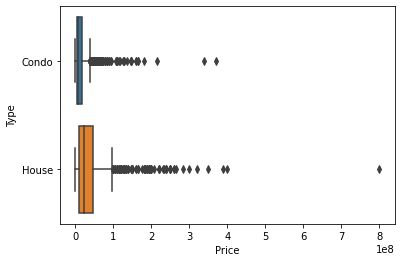

In [42]:
sns.boxplot(data=df, x='Price', y='Type')

It can be seen in the boxplot that there is a very far outlier priced at 800M.

In [43]:
df[df['Price'] > 7e8]

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Features,...,Nearby Places,URL,Timestamp,City,Region,Island,Type,NFeatures,NFacilities,NNearby Places
2269,"6 BR House and Lot in Dasmarinas Village, Maka...","Dasmarinas, Makati, Metro Manila",Kate,800000000,5.0,5.0,3.0,0,1030.0,"[Dirty Kitchen, Fully Fenced, Garage Space, Ga...",...,[],https://propertyaccess.ph/property/6-br-house-...,2022-10-23,Makati,National Capital Region,Luzon,House,8,0,0


After inspecting the property, it does seem that this is an outlier since the property is priced incorrectly. Due to that, this property will be dropped

In [44]:
df = df.drop(df[df['Price'] > 7e8].index)

<AxesSubplot:xlabel='Price', ylabel='Type'>

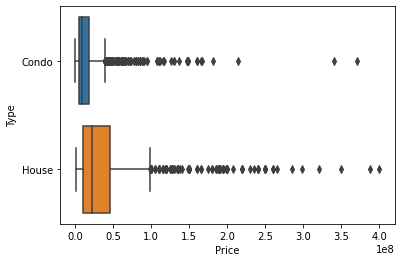

In [45]:
sns.boxplot(data=df, x='Price', y='Type')

### Export to data to clean
After the data cleaning, the total amount of properties went down to 2138 from the original 2491. This is mainly due to properties whose city cannot be identified, whose city value is an empty string, who has missing values on columns, types that cannot be indentified, and improperly priced property. Columns which had less than a hundred missing values, only the rows were dropped.The Lot Area column was dropped mainly because it more than half of the values of it were missing.  Furthermore, all the numerical values that are in string datatypes were converted to either integer or float. 

In [46]:
df.to_json('cleaned_data.json', orient='columns')

## Exploratory Data Analysis

In [ ]:
df = pd.read_json('cleaned_data.json', orient='columns')
df.head()

### How many condos and houses are there in each per city, region and island?

#### City

Text(0.5, 1.0, 'Amount of Condo and Houses in top 25 cities')

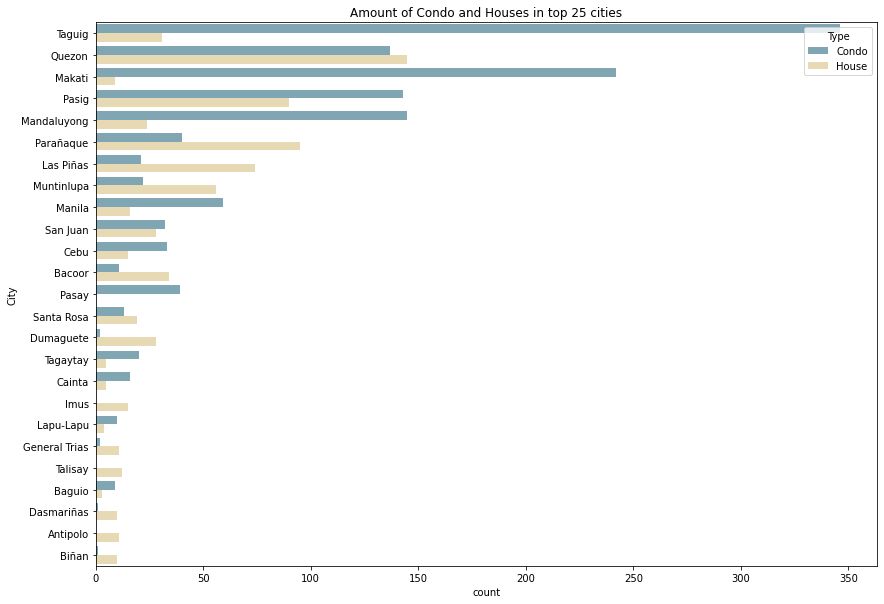

In [63]:
plt.figure(figsize=(14,10))
top_25_cities = df['City'].value_counts().index[:25]
top_25_df = df[df['City'].isin(top_25_cities)]
sns.countplot(data=top_25_df, y='City', hue='Type', palette="blend:#7AB,#EDA", order=top_25_cities)
plt.title('Amount of Condo and Houses in top 25 cities')

The bar chart contains the top 25 cities with most properties listed. The cities are sorted in a descending order based on the total amount of properties within them. However, the amount of condos and houses are seperately plotted. As can be seen the top 10 cities with most amount of listed properties are from Metro Manila. Among these, 7 out of 10 cities has more condos compared to houses. On the other hand, 8 out of 14 cities from top 11 to 24 has more houses compared to condos.

#### Region

Text(0.5, 1.0, 'Amount of Condo and Houses in each Region')

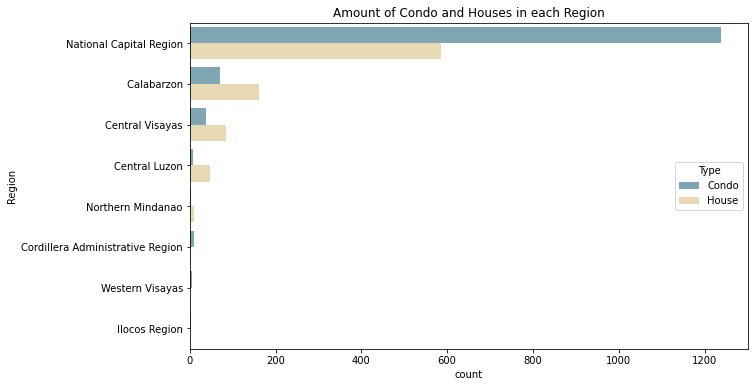

In [60]:
plt.figure(figsize=(10,6))
sorted_by_count = df.groupby('Region').count().sort_values('Type', ascending=False).index
sns.countplot(data=df, y='Region', hue='Type', palette="blend:#7AB,#EDA", order=sorted_by_count)
plt.title('Amount of Condo and Houses in each Region')

The regions are sorted based on the total amount of properties listed within it. It can clearly be seen that the NCR has the most amount of properties listed. However it is the only one aside from CAR and Western Visayas regions with more condo compared to houses.

#### Island

Text(0.5, 1.0, 'Amount of Condo and Houses in each Island')

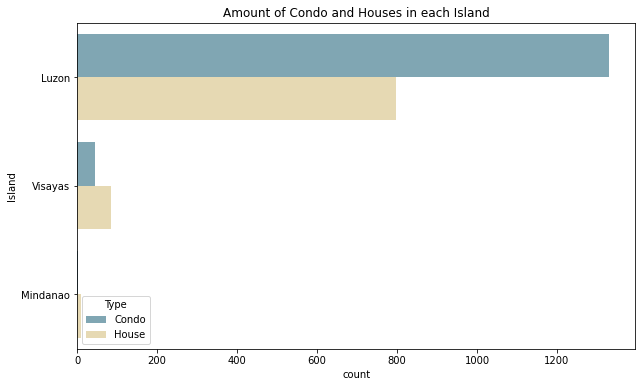

In [61]:
plt.figure(figsize=(10,6))
sorted_by_count = df.groupby('Island').count().sort_values('Type', ascending=False).index
sns.countplot(data=df, y='Island', hue='Type', palette="blend:#7AB,#EDA", order=sorted_by_count)
plt.title('Amount of Condo and Houses in each Island')

The islands are sorted based on the total amount of properties listed within it. It can be seen that there are so much more properties listed in Luzon compared to Visayas. Only Luzon has more condos compared to houses, in visayas and mindanao, there are more houses compared to condos.

### What is the price range of condos and houses per city, region and island?

#### City

Text(0.5, 1.0, 'Price Range of Condos and Houses in top 25 cities')

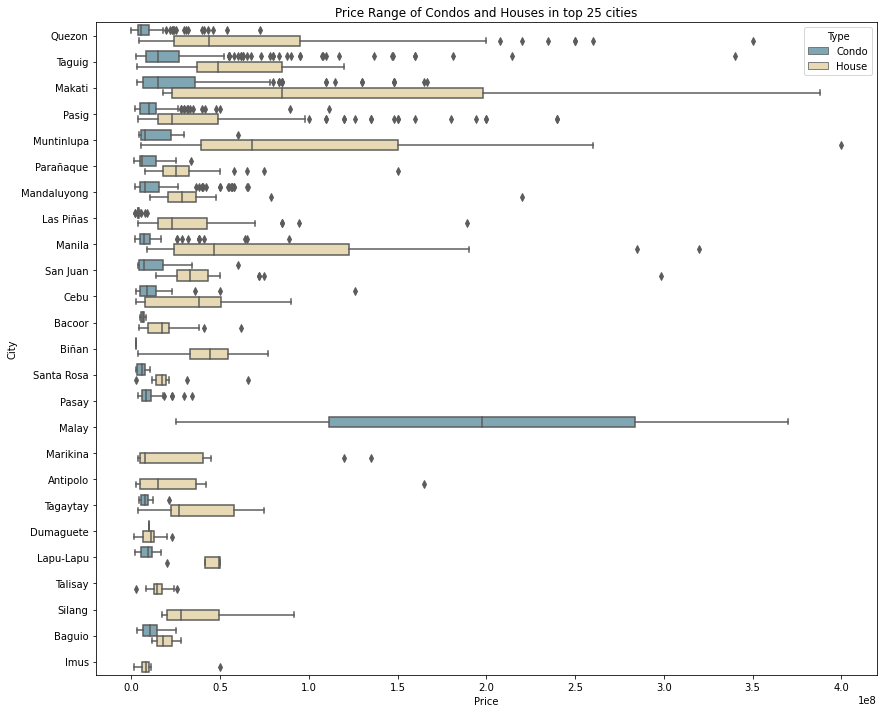

In [64]:
plt.figure(figsize=(14,12))
top_25_cities = df.groupby('City').sum().sort_values('Price', ascending=False).index[:25]
top_25_df = df[df['City'].isin(top_25_cities)]
sns.boxplot(data=df, x='Price', y='City', hue='Type', palette="blend:#7AB,#EDA", order=top_25_cities)
plt.title('Price Range of Condos and Houses in top 25 cities')

The price range of houses are shown by using a box plot based on the prices of the listed properties on top 25 cities with most expensive houses. The cities are sorted based on the total price of properties in that city. Among the listed properties, almost all of the houses in each city are generally more expensive compared to condos. Finally, the top 10 of cities with the most expensive overall, are from Metro Manila.

#### Region

Text(0.5, 1.0, 'Price Range of Condos and Houses in each Region')

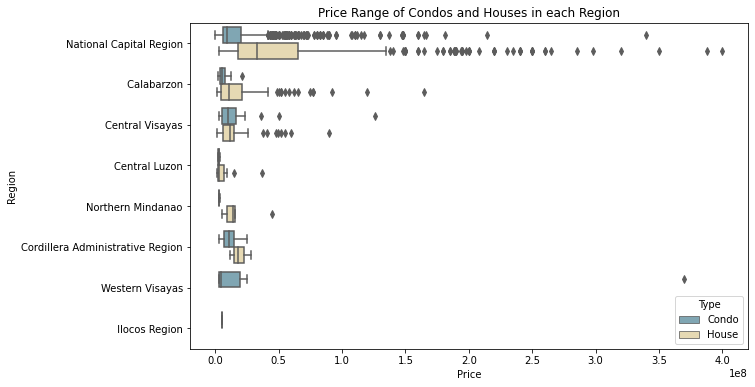

In [66]:
plt.figure(figsize=(10,6))
sorted_by_count = df.groupby('Region').count().sort_values('Type', ascending=False).index
sns.boxplot(data=df, x='Price', y='Region', hue='Type', palette="blend:#7AB,#EDA", order=sorted_by_count)
plt.title('Price Range of Condos and Houses in each Region')

The NCR has the highest price ranges out of all. Only Central Visayas has the almost the same price range between condos and houses. All the other regions have higher price on the houses compared to condos.

#### Island

Text(0.5, 1.0, 'Price Range of Condos and Houses in each Island')

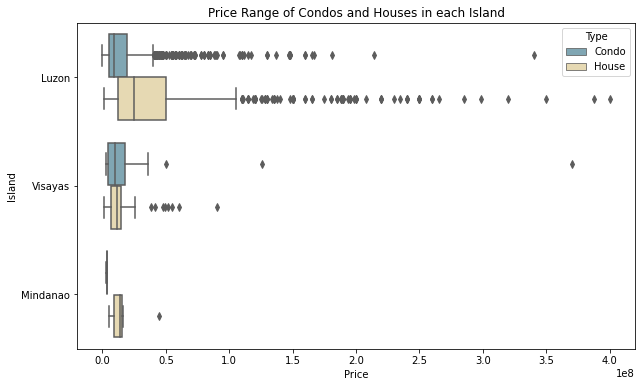

In [67]:
plt.figure(figsize=(10,6))
sorted_by_count = df.groupby('Island').count().sort_values('Type', ascending=False).index
sns.boxplot(data=df, x='Price', y='Island', hue='Type', palette="blend:#7AB,#EDA", order=sorted_by_count)
plt.title('Price Range of Condos and Houses in each Island')

It can be seen that Visayas has almost equal price range between condos and houses. Luzon has the most expensive houses and condos however, like Mindanao, Luzon also has higher price range when it comes to houses compared to condos.

### Are there any correlation between the numerical features?

Text(0.5, 1.0, 'Heatmap of Correlation between Features')

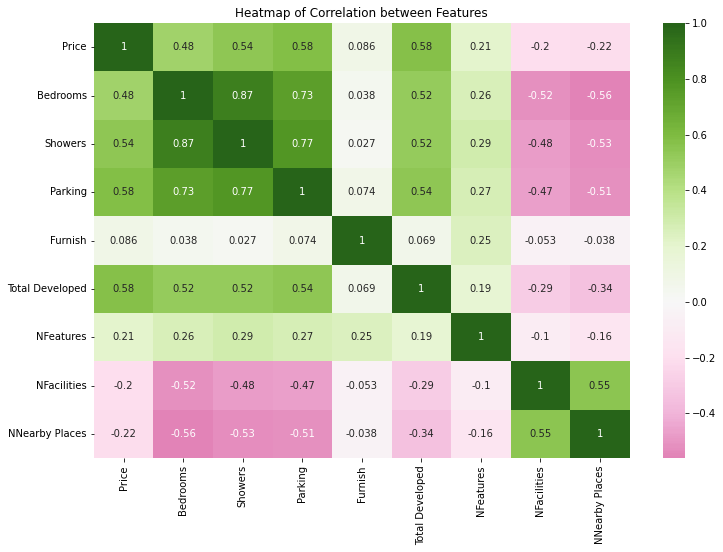

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, center=0, cmap='PiYG')
plt.title('Heatmap of Correlation between Features')

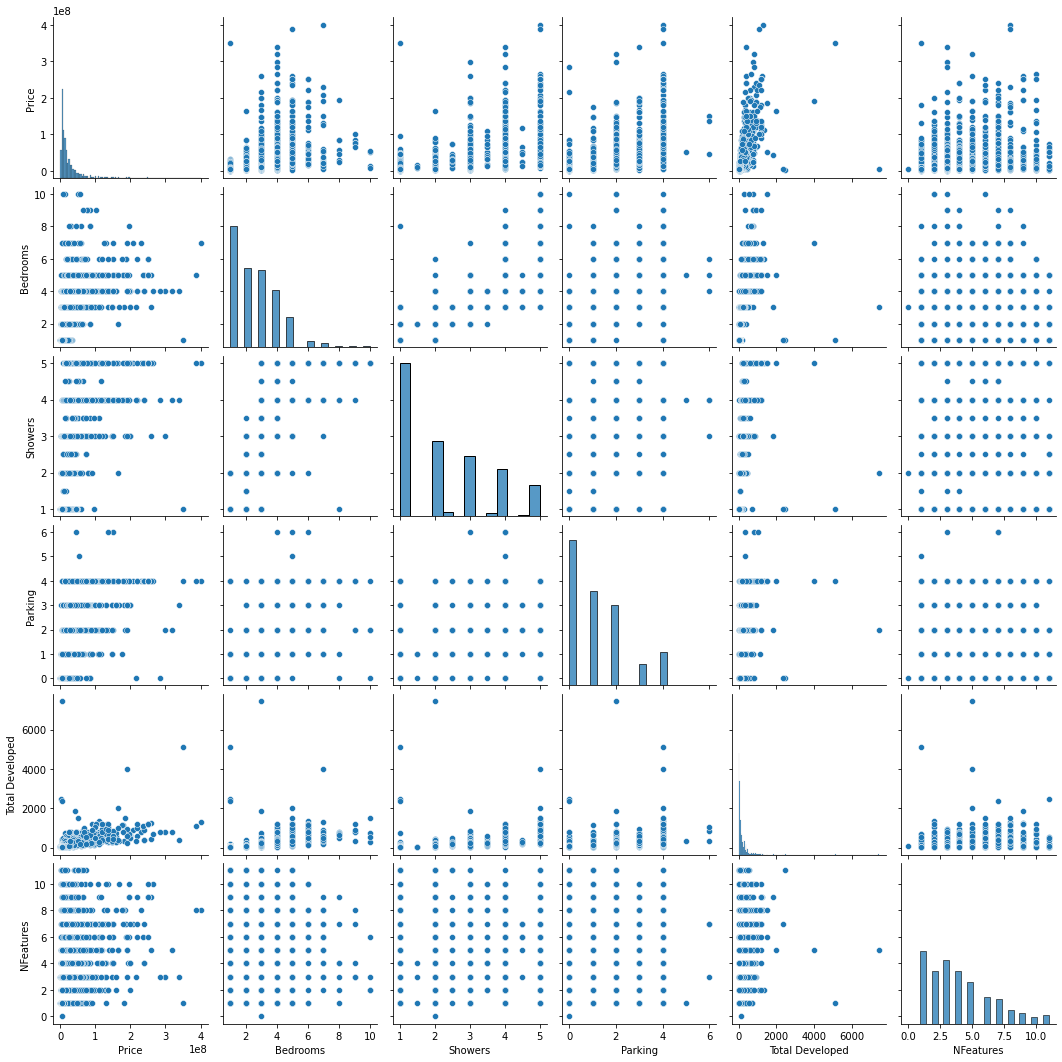

In [22]:
sns.pairplot(data = df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed', 'NFeatures']])

The price and total developed is positively correlated, valued at 0.58. The other features such as Bedrooms, Showers, Parking and Number of Features are a bit misleading because, even if it has a positive correlation, the scatter plot shows no trend. The only one with the trend would be Total Developed and the Price of the property which makes a lot of sense. It can be seen that the as the total developed area in square meter gets higher, the price of the properties becomes higher.

## Research Question

With this study, we aim to answer the following questions:
1. how many condos and lots in each city
2. what is the price range of condos and houses per city and how does (1) affect (2)
3. how much is the difference between condos and houses?
4. What type of properties are expensive or cheap? based on the grouping of features:
- lot area
- bedrooms, showers, parking
- nearby places (school, hospital, mall, etc)
- facilities (conference room, golf course, yoga studio, etc)
- unique features (gated, wifi, balcony, etc.)

**Our next step: Clustering the data to answer the specified research questions above**
- https://www.kaggle.com/code/thebrownviking20/in-depth-eda-and-k-means-clustering 